# ML with tweets

## Natural language processing
### Loading the mined data

In [1]:
import numpy as np
import pandas as pd
import sklearn as skl

df1 = pd.read_csv("C:/Users/gille/Desktop/Machine learning/Twitter mining/vaccine.csv")
df1['username'] = df1['username'].str[2:-1]
df1['username'].astype('string')
df1['username'].head()

df2 = pd.read_csv("C:/Users/gille/Desktop/Machine learning/Twitter mining/vaccination.csv")
df2['username'] = df2['username'].str[2:-1]
df2['username'].astype('string')
df2['username'].head()

df = pd.concat([df1,df2])
df = df.drop(['favourites'], axis=1)

### Remove all useless data

In [2]:
df2 = df.drop(['timestamp'], axis=1)
df3 = df2.drop_duplicates()
df4 = df3.dropna(axis=0)
print("Dataset size:", df4.shape)
df4.head()

Dataset size: (1965, 4)


,tweet_text,username,all_hashtags,followers_count
0,"You can get your 1st, 2nd &amp; 3rd #Pfizer #C...",LBofHounslow,"['Pfizer', 'Covid19', 'Hounslow', 'Covid_19', ...",15377
1,An image has been shared repeatedly in social ...,boomlive_in,"['FakeNews', 'vaccine', 'COVID19', 'Ireland']",74361
2,We are currently hearing a lot of horror news ...,ProfDrX2,"['covid', 'corona', 'satanic', 'beast', 'hoax'...",7
3,#VACC #VACCineToken #VACCine #HealthToken http...,LatifMovar,"['VACC', 'VACCineToken', 'VACCine', 'HealthTok...",4889
4,Get Free Meditation Ever🧘https://t.co/oCsO0qeC...,BatPhobia9,"['meditationmusic', 'sleepmeditation', 'guided...",104


### Clean tweet text

In [3]:
import re # A python library used for regular expressions
def clean_tweet(tweet):

    return ' '.join(re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9_]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

In [4]:
df4['tweet_text'] = df4['tweet_text'].apply(clean_tweet)
print(df4['tweet_text']) 

0      You can get your 1st 2nd amp 3rd vaccinations ...
1      An image has been shared repeatedly in social ...
2      We are currently hearing a lot of horror news ...
3      This project has a bright and amazing future I...
4                               Get Free Meditation Ever
                             ...                        
595    Today the Commissioner sir launched 15 Door to...
596        Covid studies should record women s menstrual
597    1 2 Day 320 02 Dec 7AM India update as per IND...
598     Researchers may have solved an important part of
599    The global progress of provided the much neede...
Name: tweet_text, Length: 1965, dtype: object


### Adding sentiment to the tweets

In [5]:
from textblob import TextBlob # Used to process text data
def get_tweet_polarity(text):
    '''
    Utility function to classify sentiment of passed tweet
    using textblob's sentiment method
    '''
    # create TextBlob object of passed tweet text
    analysis = TextBlob(text)
    # set sentiment
    return analysis.sentiment.polarity

df4['polarity'] = df4['tweet_text'].apply(get_tweet_polarity)
df4.head()

,tweet_text,username,all_hashtags,followers_count,polarity
0,You can get your 1st 2nd amp 3rd vaccinations ...,LBofHounslow,"['Pfizer', 'Covid19', 'Hounslow', 'Covid_19', ...",15377,0.165000
1,An image has been shared repeatedly in social ...,boomlive_in,"['FakeNews', 'vaccine', 'COVID19', 'Ireland']",74361,0.011111
2,We are currently hearing a lot of horror news ...,ProfDrX2,"['covid', 'corona', 'satanic', 'beast', 'hoax'...",7,-0.100000
3,This project has a bright and amazing future I...,LatifMovar,"['VACC', 'VACCineToken', 'VACCine', 'HealthTok...",4889,0.388333
4,Get Free Meditation Ever,BatPhobia9,"['meditationmusic', 'sleepmeditation', 'guided...",104,0.400000


In [6]:
print(df4.shape)
df5 = df4.drop(df4[df4.polarity == 0].index)
print(df5.shape)
df5.head()

(1965, 5)
(1004, 5)


,tweet_text,username,all_hashtags,followers_count,polarity
0,You can get your 1st 2nd amp 3rd vaccinations ...,LBofHounslow,"['Pfizer', 'Covid19', 'Hounslow', 'Covid_19', ...",15377,0.165000
4,Get Free Meditation Ever,BatPhobia9,"['meditationmusic', 'sleepmeditation', 'guided...",104,0.400000
7,Wow Don t miss this project guys This project ...,MDSojib68,"['VACC', 'VACCineToken', 'VACCine', 'Health']",6332,0.286667
8,Giving a in the arm to the drive quite literal...,YTHISNEWS,"['shot', 'vaccination', 'dose', 'vaccine']",256,0.050000
9,Thank you Policy for your clear and sensible w...,FranchiLiza,"['COVID19', 'Masks', 'Vaccine', 'Jabs']",867,0.100000


To be able to use our text in regression models, we create vectors from the words in every tweet text

In [7]:
import spacy

# Create an empty model
nlp = spacy.load('en_core_web_lg')

with nlp.disable_pipes():
    vectors = np.array([nlp(tweet).vector for tweet in df5['tweet_text']])
    
vectors.shape

(1004, 300)

In [8]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(vector, [i]) for i, vector in enumerate(vectors)]
vecModel = Doc2Vec(documents, vector_size=300, window=5, epochs=50, min_count=5, workers=-1)

## Creating and training the first model: SVR

In [9]:
from sklearn import svm
X = vectors
y = df5['polarity']

regrModel = svm.SVR()
regrModel.fit(X, y)
regrModel.score(X, y)

0.6314018346877833

In [10]:
from sklearn.metrics import mean_absolute_error

predictions1 = regrModel.predict(X)
mean_absolute_error(y, predictions1)

0.14001156016627095

## Creating and training the second model: RANSACRegressor

In [11]:
from sklearn.linear_model import RANSACRegressor
from sklearn.datasets import make_regression

RANSACreg = RANSACRegressor(random_state=0).fit(X, y)
RANSACreg.score(X, y)

predictions2 = RANSACreg.predict(X)
mean_absolute_error(y, predictions2)

0.46513693589805366

## Testing the models
### Retrieving and cleaning test data

In [12]:
df_test = pd.read_csv("C:/Users/gille/Desktop/Machine learning/Twitter mining/cat.csv")
df_test['username'] = df_test['username'].str[2:-1]
df_test['username'].astype('string')
df_test['username'].head()
df_test = df_test.drop('timestamp', axis=1)

df_test['tweet_text'] = df_test['tweet_text'].apply(clean_tweet)

In [13]:
df_test['polarity'] = df_test['tweet_text'].apply(get_tweet_polarity)

In [14]:
print(df_test.shape)
df_test = df_test.drop(df_test[df_test.polarity == 0].index)
print(df_test.shape)
df_test.head()

(200, 5)
(124, 5)


,tweet_text,username,all_hashtags,followers_count,polarity
0,Project Report 2021 Manufacturing Process Plan...,JamieCo78336894,"['Cat', 'Food']",0,-0.230769
1,90min Edit my highlights Have Get from my Be r...,kilzorgaming,"['workout', 'twitchstreaming', 'breakfast', 'c...",29,0.200000
2,A cat s eyesight is both better and worse than...,ArielPinco,"['Cat', 'CatFact']",22,0.114286
5,Good Education is a Foundation for a Better fu...,lcbs_dhaka,"['LCBS', 'LCBS_Dhaka', 'success_Story', 'Congr...",20,0.487500
6,Money can buy you a fine but only can make him...,PlusBeds,"['dog', 'love', 'wag', 'tail', 'dogs', 'puppy'...",141,0.208333


In [15]:
with nlp.disable_pipes():
    test_vectors = np.array([nlp(tweet).vector for tweet in df_test['tweet_text']])
    
test_vectors.shape

(124, 300)

### Mean absolute error

In [16]:
from sklearn.metrics import mean_absolute_error

X_test = test_vectors
y_test = df_test['polarity']

y_pred1 = regrModel.predict(X_test)
y_pred2 = RANSACreg.predict(X_test)

print("Mean squared error for SVR: " + str(mean_absolute_error(y_test, y_pred1)))
print("Mean squared error for RANSACRegressor: " + str(mean_absolute_error(y_test, y_pred2)))

Mean squared error for SVR: 0.21156409695029968
Mean squared error for RANSACRegressor: 1.1875760714916923


### Coëfficient of determination

In [17]:
print("Coëfficient of determination (R^2) for SVR: " + str(regrModel.score(X_test, y_test)))
print("Coëfficient of determination (R^2) for RANSACRegressor: " + str(RANSACreg.score(X_test, y_test)))

Coëfficient of determination (R^2) for SVR: 0.2480441831959157
Coëfficient of determination (R^2) for RANSACRegressor: -26.609776246007264


### Visual comparison of 2 models

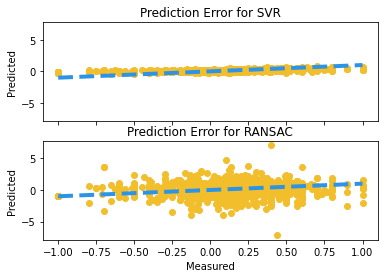

In [21]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict

def error_compare(mods,X,y):
    f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)
    for mod, ax in ((mods[0], ax1),(mods[1], ax2)):
        predicted = cross_val_predict(mod[0], X, y, cv=12)
        ax.scatter(y, predicted, c='#F2BE2C')
        ax.set_title('Prediction Error for %s' % mod[1])
        ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4, c='#2B94E9')
        ax.set_ylabel('Predicted')
    plt.xlabel('Measured')
    plt.savefig('prediction_error.png', bbox_inches="tight")
    
models = np.array([(svm.SVR(),'SVR'), (RANSACRegressor(),'RANSAC')])
error_compare(models, X,y)

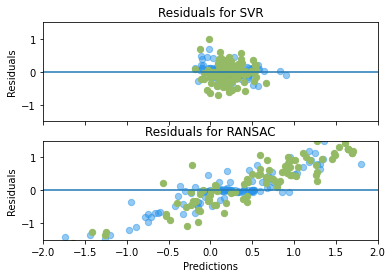

In [24]:
from sklearn.model_selection import train_test_split

def resids_compare(mods,X,y):
    f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)
    plt.title('Plotting residuals using training (blue) and test (green) data')
    for m, ax in ((mods[0], ax1),(mods[1], ax2)):
        m[0].fit(X, y)
        ax.scatter(m[0].predict(X[:124]), m[0].predict(X[:124])-y[:124],c='#2B94E9',s=40,alpha=0.5)
        ax.scatter(m[0].predict(X_test), m[0].predict(X_test)-y_test,c='#94BA65',s=40)
        ax.hlines(y=0, xmin=-10, xmax=100)
        ax.set_title('Residuals for %s' %m[1])
        ax.set_ylabel('Residuals')
    ax2.set_xlabel('Predictions')    
    plt.xlim([-2, 2])        # Adjust according to your dataset
    plt.ylim([-1.5,1.5])  
    plt.savefig('residuals.png', bbox_inches="tight")
    
models = np.array([(svm.SVR(),'SVR'), (RANSACRegressor(),'RANSAC')])
resids_compare(models, X,y)